In [1]:
#package
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from WindPy import w
# follow 20241118-上海申银万国证券研究所-数说资产配置系列之十一：盈利、情绪和需求预期：市场信息对宏观量化模型的修正
# follow 20250609-上海申银万国证券研究所-全天候策略再思考：多资产及权益内部的应用实践

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 主成分分析

In [3]:
'''
stock:
沪深300 - 000300.SH
中证500 - 000905.SH
中证1000 - 000852.SH

跨境股票:
标普500 - SPX.GI

债券:
中债7-10年政策性金融债 - CBA08203.CS
中债1-3年国债 - 931552.CSI

商品或其他:
黄金(Au9999) - AU9999.SGE
大商所豆粕期货 - M.DCE
华夏中国交建REIT - 508018.SH #剔除
'''
investment_pool = ['000300.SH','000905.SH','000852.SH','SPX.GI','CBA08203.CS','931552.CSI','AU9999.SGE','M.DCE']
# str = ','.join(investment_pool)
# history_data=w.wsd(str,
#                    "close", 
#                    "2012-01-01", 
#                    "2025-9-30",  
#                    'Period=M',
#                    usedf=True) 
# price_data = history_data[1]
# price_data.to_csv('./price_data/micro_research_price_data.csv')
price_data = pd.read_csv('D:/program_learning/GD_security_working/asset_alloc/price_data/micro_research_price_data.csv',index_col=0,parse_dates=True)
price_data

,000300.SH,000905.SH,000852.SH,SPX.GI,CBA08203.CS,931552.CSI,AU9999.SGE,M.DCE
2012-01-31,2464.2600,3294.4940,3406.6750,1312.41,100.5874,115.4840,354.16,2943.0
2012-02-29,2634.1430,3696.1440,3858.5420,1365.68,98.9514,115.4220,361.96,3138.0
2012-03-30,2454.8990,3416.8560,3560.4850,1408.47,98.7931,116.0090,339.04,3244.0
2012-04-27,2626.1570,3664.6380,3837.8780,1397.91,97.7315,116.2120,336.09,3345.0
2012-05-31,2632.0420,3753.5930,3898.5910,1310.33,100.0414,117.5180,321.75,3145.0
...,...,...,...,...,...,...,...,...
2025-05-30,3840.2323,5671.0723,6026.5603,5911.69,123.7543,173.6745,768.79,2968.0
2025-06-30,3936.0791,5915.3876,6356.1813,6204.95,124.0135,174.1445,764.43,2961.0
2025-07-31,4075.5912,6226.3432,6661.1862,6339.39,123.2563,174.2714,767.36,3000.0
2025-08-29,4496.7591,7043.9416,7438.6767,6460.26,122.3327,174.5363,781.71,3055.0


In [62]:
ret_data = price_data.pct_change().iloc[1:]
cum12_ret_data= ret_data.rolling(window=12).apply(lambda x: (1+x).prod()-1).iloc[11:].loc[:"2021-01-01"]


In [64]:
cum12_ret_data_standardize = (cum12_ret_data - cum12_ret_data.mean()) / cum12_ret_data.std()

In [65]:
from Util_Fin.PCAanalysis import PCAAnalyzer
import matplotlib.pyplot as plt
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

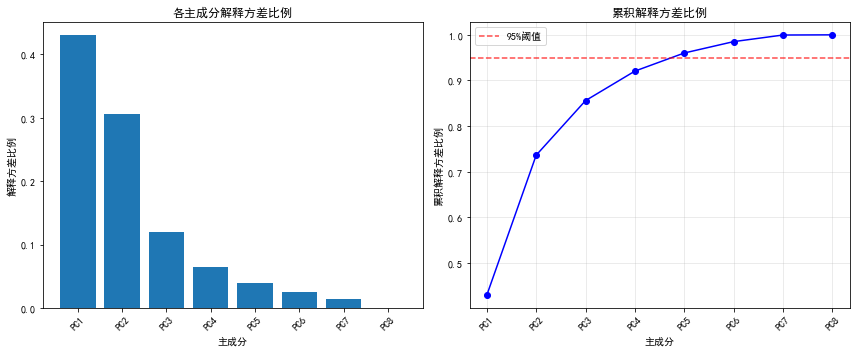

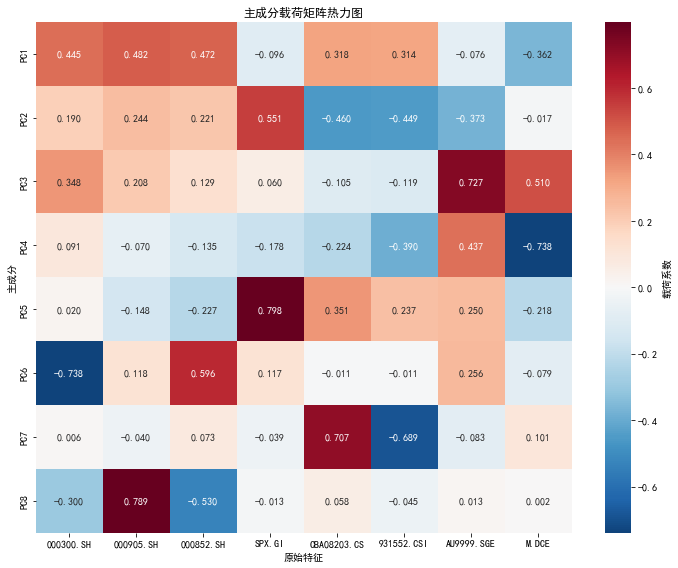

In [66]:
pca_analyzer = PCAAnalyzer(standardize=True)
pca_analyzer.fit(cum12_ret_data_standardize)

# 获取分析结果
summary = pca_analyzer.get_summary_statistics()
components = pca_analyzer.get_components_matrix()

# 可视化
pca_analyzer.plot_explained_variance()
pca_analyzer.plot_components_heatmap()


In [67]:
pca_ret = pd.DataFrame(pca_analyzer.transform(),index=cum12_ret_data_standardize.index).iloc[:,:-2]
pca_ret.to_csv("pca_series.csv")

# 宏观数据获取

In [10]:
'''
获取宏观数据
经济:  工业增加值当月同比的滚动 3 个月平均 # M0061675-Wind一致预期 # M0000545-规模以上工业企业增加值 *
流动性: 10 年期国债到期收益率  # S0059749-中债10年期国债到期收益率 *  # M1001654-中国10年期国债到期收益率
通胀: CPI同比  # M0061676-Wind一致预期CPI同比 # M0000612-CPI当月同比 * 
通胀: PPI同比 # M0061677-Wind一致预期PPI同比 # M0001227-PPI当月同比 * 
信用: 累计12个月新增社融同比增速 # M5206731 社融:新增人民币贷款 
                            # M5206732 社融:新增外币贷款 
                            # M5206733 社融:新增委托贷款 
                            # M5206734 社融:新增信托贷款
                            # M5206735 社融:新增未贴现银行汇票
'''


'\n获取宏观数据\n经济:  工业增加值当月同比的滚动 3 个月平均 # M0061675-Wind一致预期 # M0000545-规模以上工业企业增加值 *\n流动性: 10 年期国债到期收益率  # S0059749-中债10年期国债到期收益率 *  # M1001654-中国10年期国债到期收益率\n通胀: CPI同比  # M0061676-Wind一致预期CPI同比 # M0000612-CPI当月同比 * \n通胀: PPI同比 # M0061677-Wind一致预期PPI同比 # M0001227-PPI当月同比 * \n信用: 累计12个月新增社融同比增速 # M5206731 社融:新增人民币贷款 \n                            # M5206732 社融:新增外币贷款 \n                            # M5206733 社融:新增委托贷款 \n                            # M5206734 社融:新增信托贷款\n                            # M5206735 社融:新增未贴现银行汇票\n'

In [113]:
# 1.关于GDP
# macro_data = w.edb("M0061675,M0000545,S0059749,M1001654,M0061676,M0000612,M0061677,M0001227,M5206731,M5206732,M5206733,M5206734,M5206735",
#                    "2009-01-01",
#                    "2025-10-27",
#                    "Fill=Previous",
#                    'Period=M',
#                    usedf=True)
# macro_data = macro_data[1]
# macro_data.to_csv("./price_data/macro_social_data.csv")
macro_data = pd.read_csv("D:/program_learning/GD_security_working/asset_alloc/price_data/macro_social_data.csv", index_col=0,parse_dates=True)
macro_data = macro_data.resample('M').last().dropna().loc[:'2021-01-01']
# macro_data.resample("Y").count()

In [114]:
macro_data['新增社融'] = macro_data[['M5206731', 'M5206732', 'M5206733', 'M5206734', 'M5206735']].sum(axis=1)
macro_data['S0059749'] = 1/macro_data['S0059749']
macro_data['累计12个月新增社融'] = macro_data['新增社融'].rolling(12).sum()
macro_data['累计12个月新增社融同比增速'] = macro_data['累计12个月新增社融'].pct_change(12)
macro_data['工业增加值同比增速三月平均'] = macro_data['M0000545'].rolling(3).mean()

In [115]:
macro_data_cal = macro_data[['工业增加值同比增速三月平均','S0059749','M0000612','M0001227', '累计12个月新增社融同比增速']]
macro_data_cal.columns = ['工业增加值同比增速三月平均','10年期国债到期收益率','CPI同比','PPI同比','社融同比增速']
macro_data_cal = macro_data_cal.loc['2013-01-31':]
macro_data_cal.index = pca_ret.index

In [116]:
macro_data_cal.to_csv("macro_data_cal.csv")

In [117]:
macro_data_cal

,工业增加值同比增速三月平均,10年期国债到期收益率,CPI同比,PPI同比,社融同比增速
2013-01-31,12.700000,0.277362,2.0305,-1.64,0.421650
2013-02-28,10.066667,0.278110,3.2198,-1.63,0.382785
2013-03-29,9.600000,0.282550,2.0696,-1.92,0.418646
2013-04-26,6.800000,0.291426,2.3861,-2.62,0.540927
2013-05-31,9.133333,0.290706,2.0981,-2.87,0.536493
...,...,...,...,...,...
2020-08-31,5.066667,0.331378,2.4000,-2.00,0.354567
2020-09-30,5.766667,0.317642,1.7000,-2.10,0.325303
2020-10-30,6.466667,0.314367,0.5000,-2.10,0.337991
2020-11-30,6.933333,0.307692,-0.5000,-1.50,0.316934


In [118]:
#标准化
macro_data_cal_1 = ((macro_data_cal - macro_data_cal.mean()) / macro_data_cal.std())*0.1
macro_data_cal_1.describe()

,工业增加值同比增速三月平均,10年期国债到期收益率,CPI同比,PPI同比,社融同比增速
count,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,96.000000
mean,1.387779e-17,-3.527271e-17,-2.226228e-17,-1.879284e-18,0.000000
std,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01,0.100000
min,-5.234985e-01,-1.928378e-01,-2.880346e-01,-1.533612e-01,-0.167484
25%,-1.526429e-02,-5.377032e-02,-5.921725e-02,-6.313493e-02,-0.081333
50%,-1.452323e-03,-1.021685e-02,-9.716480e-03,-2.962342e-02,-0.030269
75%,4.050479e-02,7.110034e-02,3.884734e-02,8.524668e-02,0.073469
max,1.997333e-01,2.394117e-01,3.548333e-01,2.216720e-01,0.213680


In [119]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [120]:
def lasso_projection(Y,X):
    common_vars = Y.index.intersection(X.index)
    
    Y = Y.loc[common_vars]
    X = X.loc[common_vars]
    print(f"\n对齐后的数据长度:{len(Y)}")

    #存储投影结果
    projected_Y = pd.DataFrame(index=common_vars,columns=Y.columns)
    results_summary = {}
    # 对每个宏观变量进行Lasso投影
    for macro_var in Y.columns:
        print(f"\n处理宏观变量: {macro_var}")
        y = Y[macro_var].values
        X_lasso = X.values
        lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 1000), 
                           cv=5, 
                           random_state=100,
                           max_iter=2000)
        lasso_cv.fit(X_lasso, y)

        best_alpha = lasso_cv.alpha_
        coefficients = lasso_cv.coef_
        if abs(lasso_cv.predict(X_lasso).mean()) >= 1e-4:
            projected_values = lasso_cv.predict(X_lasso)
        else:
            projected_values = y
        projected_Y[macro_var] = projected_values
        # 计算交叉验证分数
        cv_scores = cross_val_score(lasso_cv, X_lasso, y, cv=5, scoring='neg_mean_squared_error')
        mean_cv_score = -cv_scores.mean()
        results_summary[macro_var] = {
            'best_alpha': best_alpha,
            'coefficients': coefficients,
            'cv_mse': mean_cv_score,
            'non_zero_components': np.sum(np.abs(coefficients) > 1e-6)
        }

        print(f"  最优alpha: {best_alpha:.6f}")
        print(f"  交叉验证MSE: {mean_cv_score:.6f}")
        print(f"  非零主成分数量: {results_summary[macro_var]['non_zero_components']}")
        print(f"  系数: {coefficients}")
    return projected_Y, results_summary


In [121]:
projected_macro, results_summary = lasso_projection(macro_data_cal_1, pca_ret)


对齐后的数据长度:96

处理宏观变量: 工业增加值同比增速三月平均
  最优alpha: 0.003448
  交叉验证MSE: 0.010640
  非零主成分数量: 5
  系数: [-0.00195004  0.03158686 -0.03497451 -0.01361568  0.00110954 -0.        ]

处理宏观变量: 10年期国债到期收益率
  最优alpha: 0.000865
  交叉验证MSE: 0.005071
  非零主成分数量: 6
  系数: [ 0.00145312 -0.04712971  0.03983407  0.02374002 -0.01277862  0.02850223]

处理宏观变量: CPI同比
  最优alpha: 10000.000000
  交叉验证MSE: 0.011716
  非零主成分数量: 0
  系数: [-0. -0.  0.  0.  0.  0.]

处理宏观变量: PPI同比
  最优alpha: 0.003323
  交叉验证MSE: 0.012203
  非零主成分数量: 6
  系数: [-0.03240133  0.01373343  0.0164464   0.01233701  0.00493795 -0.07714279]

处理宏观变量: 社融同比增速
  最优alpha: 0.008830
  交叉验证MSE: 0.008747
  非零主成分数量: 4
  系数: [-0.01756868  0.02748751  0.01384165  0.04361103 -0.         -0.        ]


In [122]:
projected_macro

,工业增加值同比增速三月平均,10年期国债到期收益率,CPI同比,PPI同比,社融同比增速
2013-01-31,0.199733,-0.049839,-0.012310,-0.035899,0.142895
2013-02-28,0.117383,-0.047984,0.117277,-0.035626,0.126346
2013-03-29,0.102789,-0.036975,-0.008049,-0.043539,0.141616
2013-04-26,0.015226,-0.014964,0.026437,-0.062638,0.193687
2013-05-31,0.088195,-0.016750,-0.004944,-0.069460,0.191799
...,...,...,...,...,...
2020-08-31,-0.038979,0.084103,0.027951,-0.045722,0.114330
2020-09-30,-0.017089,0.050042,-0.048321,-0.048450,0.101868
2020-10-30,0.004802,0.041920,-0.179074,-0.048450,0.107271
2020-11-30,0.019396,0.025370,-0.288035,-0.032079,0.098305


In [123]:
beta_df = pd.DataFrame(index=cum12_ret_data_standardize.columns, columns=projected_macro.columns)
for asset in cum12_ret_data_standardize.columns:
    Y = cum12_ret_data_standardize[asset].values
    X = projected_macro.values
    std_Y = Y.std()
    beta = (X.T@X)@X.T@Y/std_Y
    beta_df.loc[asset] = beta
beta_df

,工业增加值同比增速三月平均,10年期国债到期收益率,CPI同比,PPI同比,社融同比增速
000300.SH,1.064619,-0.54698,-2.005533,-1.943296,-1.205454
000905.SH,2.137134,-1.26032,-2.123484,-3.994655,-2.303619
000852.SH,2.024843,-0.808372,-1.734924,-5.413209,-3.111006
SPX.GI,8.628331,-9.950738,-2.210016,5.497105,5.473099
CBA08203.CS,-6.122456,8.046442,1.236699,-8.348984,-7.943429
931552.CSI,-5.886187,7.040254,1.401827,-7.69099,-9.062389
AU9999.SGE,-10.69659,10.609509,4.895829,-0.617478,-0.140024
M.DCE,-1.544787,0.722383,0.894836,4.055296,2.364028


In [125]:
import pandas as pd
 
def create_ranked_names_df(df):
    # 创建空DataFrame存放结果
    max_rank = len(df)
    dfB = pd.DataFrame(
        index=range(1, max_rank+1),
        columns=df.columns, 
        dtype=str 
    )
    dfB.index.name  = 'Rank'
    
    # 处理每个科目
    for factor in df.columns: 
        factor_data = df.copy()    
        factor_data['Name'] = factor_data.index  
        factor_data = factor_data.sort_values( 
            by=[factor, 'Name'],
            ascending=[False, True]
        )
        # 生成排名索引 
        factor_data.index  = range(1, len(factor_data)+1)
        
        # 填充到结果DataFrame
        dfB[factor] = factor_data['Name']
    
    return dfB
 

dfB = create_ranked_names_df(beta_df)


In [126]:
dfB

,工业增加值同比增速三月平均,10年期国债到期收益率,CPI同比,PPI同比,社融同比增速
Rank,,,,,
1,SPX.GI,AU9999.SGE,AU9999.SGE,SPX.GI,SPX.GI
2,000905.SH,CBA08203.CS,931552.CSI,M.DCE,M.DCE
3,000852.SH,931552.CSI,CBA08203.CS,AU9999.SGE,AU9999.SGE
4,000300.SH,M.DCE,M.DCE,000300.SH,000300.SH
5,M.DCE,000300.SH,000852.SH,000905.SH,000905.SH
6,931552.CSI,000852.SH,000300.SH,000852.SH,000852.SH
7,CBA08203.CS,000905.SH,000905.SH,931552.CSI,CBA08203.CS
8,AU9999.SGE,SPX.GI,SPX.GI,CBA08203.CS,931552.CSI
